In [304]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from preprocess import train_features

In [305]:
df_train = pd.read_csv('final_train_df.csv',index_col=['id_number','name','price'])

In [306]:
submission_df = pd.read_csv('Submission_preprocess.csv')

In data preprocessing I transformed price as log(price). Because for model easy to predict small values. But for the baseline model, I used regular price values.

In [318]:
not_binary_features = [
    'host_since',
    'host_response_rate',
    'host_acceptance_rate',
    'accommodates',
    'bathrooms',
    'bedrooms',
    'beds',
    'cleaning_fee',
    'guests_included',
    'minimum_nights',
    'maximum_nights',
    'number_of_reviews',
    'review_scores_rating',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
    'calculated_host_listings_count',
    'reviews_per_month'
] 

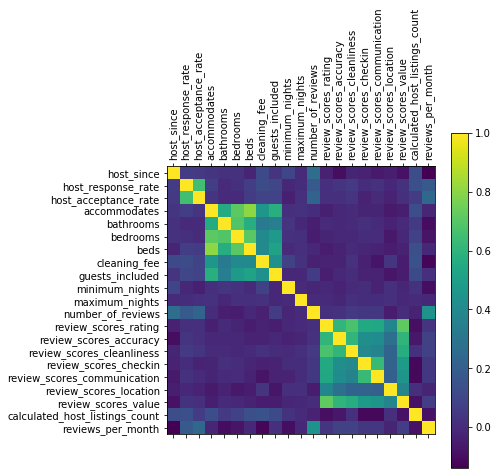

In [319]:
f = plt.figure(figsize=(6, 6))
plt.matshow(df_train[columns_to_scale_train].corr(), fignum=f.number)
plt.xticks(range(df_train[not_binary_features].shape[1]), columns_to_scale_train, fontsize=10, rotation=90)
plt.yticks(range(df_train[not_binary_features].shape[1]), columns_to_scale_train, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)

### Evaluation metric
We need a relative metric because if we have true value = 500 and predict value = 450. We made a mistake of 50 in absolute value, but relative it's 10%. In another case true = 100 and predict = 50, absolute error is 50 but it's 50% of the exact price. It is important for us how much percent we are mistaken

In [320]:
def evaluation_metrics(y_true,y_pred):
    error = (y_true - y_pred)/y_true
    return error

### Train test split

In [321]:
X_train, X_test = train_test_split(df_train, test_size=0.3, random_state=42)

### beseline model
I use LinearRegression as a simple baseline with several base features.

In [322]:
X_train_baseline, X_validation_baseline, y_train_baseline, y_validation_baseline = train_test_split(X_train.drop(columns = 'price_log'),X_train.reset_index().price, test_size=0.3, random_state=42)

In [323]:
base_features = [
    'host_response_rate',
    'bathrooms',
    'bedrooms',
    'beds', 
    'cleaning_fee',
    'reviews_per_month'
    'guests_included',
    'number_of_reviews',
]

In [324]:
baselinemodel = LinearRegression()

In [325]:
baselinemodel.fit(X_train_baseline, y_train_baseline)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

evaluate baseline model on part of train dataset 

In [326]:
pred_valid = baselinemodel.predict(X_validation_baseline)
err_valid = evaluation_metrics(y_validation_baseline,pred_valid)
print(f'mean baseline valid error: {err_valid.mean()}, std of baseline valid error: {err_valid.std()}')

mean baseline valid error: -0.14696894534233254, std of baseline valid error: 0.7225356001098006


In [327]:
# baseline predicton 
baseline_predict = baselinemodel.predict(X_test.drop(columns = 'price_log'))

### Train model
I used xgboost regression bacause of mixed features type, categorical and numerical. 

At first I check model with simple parameters on cross validation

In [328]:
params = {
    'colsample_bytree': 0.4,
    'gamma': 0,
    'learning_rate': 0.01,
    'max_depth': 5,
    'n_estimators': 1000
}

In [329]:
model = xgboost.XGBRegressor(**params)

In [330]:
kfold = KFold(n_splits=10, random_state=42)

/home/yevheniia/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [331]:
scoring = 'neg_mean_squared_error'
results = cross_val_score(model, X_train.drop(columns = 'price_log'),X_train.price_log, cv=kfold, scoring=scoring)

In [332]:
print(results.mean(), results.std())

-0.11899316049784729 0.02202344132210938


With GridSearchCV I tuned 2 parameters max_depth and learning_rate

In [333]:
params = {
    'colsample_bytree': 0.4,
    'gamma': 0,
    'n_estimators': 1000
}
model = xgboost.XGBRegressor(**params)
param_space = {"max_depth": [ 3, 6, 9],"learning_rate": [0.01, 0.05, 0.1]}
cv = KFold(4, random_state=42,shuffle=True)

In [334]:
gsearch = GridSearchCV(
    estimator=model,
    param_grid=param_space,
    n_jobs=4,
    scoring=scoring,
    cv=cv,
    verbose=True,
        )
x_train = X_train.drop(columns = 'price_log')
y_train = X_train.price_log
gsearch.fit(x_train, y_train)
print(
    "Best params found: ",
    gsearch.best_params_,
    "\nwith score: ",
    gsearch.best_score_,
)

Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:   30.0s finished


Best params found:  {'learning_rate': 0.01, 'max_depth': 9} 
with score:  -0.12055398562912822


In [335]:
best_params = gsearch.best_params_
model = gsearch.best_estimator_

### Test
Make prediction with xgb and transform value exponent^(predict_value)

In [336]:
X_test.drop(columns = 'price_log').columns

Index(['host_since', 'host_response_rate', 'host_acceptance_rate',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'cleaning_fee',
       'guests_included', 'minimum_nights', 'maximum_nights',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count',
       'reviews_per_month', 'host_response_rate_nan',
       'host_acceptance_rate_nan', 'Capitol Hill', 'Columbia Heights',
       'Dupont Circle', 'Logan Circle', 'U Street Corridor', 'Adams Morgan',
       'Near Northeast/H Street Corridor', 'Shaw', 'city_one_hot',
       'state_one_hot', 'property_type_house', 'property_type_other',
       'Private room', 'Shared room', 'bed_type_not_real_bed',
       'instant_bookable_not_f', 'moderate', 'strict', 'super_strict_30',
       'email', 'facebook', 'google', 'jumio', 'kba', 'l

In [337]:
y_predict_log = model.predict(X_test.drop(columns = 'price_log'))
y_predict = np.exp(y_predict_log)

In [338]:
y_true = X_test.reset_index().price

In [339]:
err = evaluation_metrics(y_true,y_predict)
err_baseline = evaluation_metrics(y_true,baseline_predict)

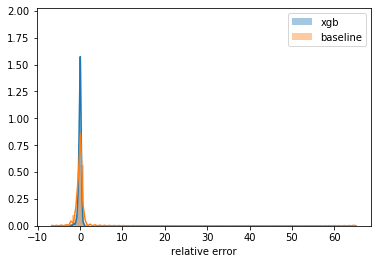

In [340]:
sns.distplot(err,label = 'xgb')
sns.distplot(err_baseline,label = 'baseline')
plt.xlabel('relative error')
plt.legend()
plt.show()

We see that the mean errors of the two models are not critically different, but we also see the big problem of the baseline model. There are a lot of outliers in the predictions of the base model and we can make a mistake by a very large percentage. The stability of the model is a very important. 

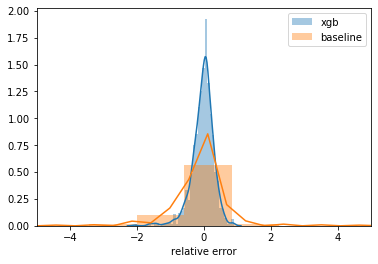

In [362]:
sns.distplot(err,label = 'xgb')
sns.distplot(err_baseline,label = 'baseline')
plt.xlabel('relative error')
plt.xlim(-5,5)
plt.legend()
plt.show()

Looking even closer, our model is still better at predicting exact prices

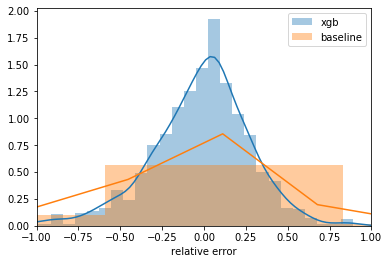

In [363]:
sns.distplot(err,label = 'xgb')
sns.distplot(err_baseline,label = 'baseline')
plt.xlabel('relative error')
plt.xlim(-1,1)
plt.legend()
plt.show()

In [341]:
print(f'mean baseline error: {err_baseline.mean()}, std of baseline error: {err_baseline.std()}')
print(f'mean error: {err.mean()}, std of error: {err.std()}')

mean baseline error: -0.0749814371945911, std of baseline error: 2.2588190727156046
mean error: -0.03636712315653585, std of error: 0.3316481621066342


In [342]:
pickle.dump(model, open("xgb_regression.dat", "wb"))

### Submission

In [364]:
y_predict_log_submission = model.predict(submission_df)
y_predict_submission = np.exp(y_predict_log_submission)

In [365]:
submission_original = pd.read_csv('Submission.csv')

In [366]:
submission_original.loc[:,'price_prediction'] = y_predict_submission

In [367]:
submission_original.to_csv('Submission_with_price_prediction.csv')

## Future work
* model tuning. this is only an initial prototype. the results are better than the baseline, but not great
* additional **feature selection**. Our model may benefit if we decrease dimensionality.
* text information extracting - description field and keywords from there might be useful
* additional feature engineering: i.e. number of rooms, distric and neighborhood data (maybe, from external sources)
* overfitting check (i performed K-fold validation to be safe)
* hyperparameter tuning (optuna ,i.e.)

## Impact factors

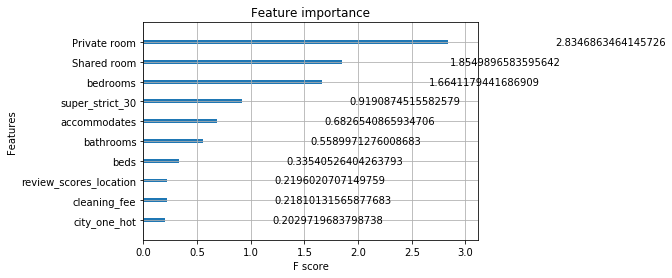

In [371]:
xgb.plot_importance(model, max_num_features=10, importance_type='gain')

Price impact factor can be explored from our model.

We see that the most influential factors are:
 * room type
 * number of bedrooms 
 * booking policy
 
This is not ideal "impact factor" detection, but still it provides useful (and reasonable) explanation

## Business value

I see 2 beneficials from this model:
* **apartment host** will have an insight on how to increase pricing: what amenties to add, write answers quicker, make a better description, or make better photos (we can analyze them as well)
* **platform owner** need an insight about their customers: what are the renting, how often, in which locations and when. He want to increase both the number of users and hosts, so he will be interested in simplifying their user experience (as I described in the previous point) 